## Contrastive learning: learning a Gaussian mixture pdf using a neural net

In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal, rv_continuous
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

### Data - setting up distributions

This is our Gaussian mixture class.

It's not implemented very robustly but is enough to generate samples and compare the neural net to its pdf p.

In [3]:
class Mixture(rv_continuous):
    def __init__(self, *args):
        self.distns = args
        super().__init__()
        
    def pdf(self, x):
        return np.mean([d.pdf(x) for d in self.distns])
    
    def rvs(self, size=1):
        samples = [d.rvs(size=size) for d in self.distns]
        indices = np.random.randint(low=0, high=len(self.distns), size=size)
        return np.array([samples[indices[i]][i] for i in range(size)])

We use one component with mean (1,1)^T, the other with (-1,-1)^T

In [4]:
mixture_component_1 = multivariate_normal([1, 1], [[0.25, 0], [0, 0.25]])
mixture_component_2 = multivariate_normal([-1, -1], [[0.25, 0], [0, 0.25]])
true_mixture = Mixture(mixture_component_1, mixture_component_2)

Let's visualise the pdf...

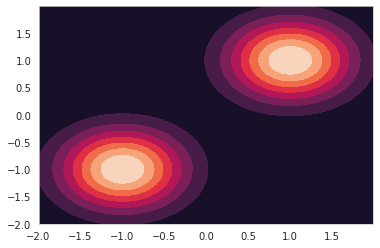

In [5]:
x1, x2 = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((x1, x2))
_ = plt.contourf(x1, x2, np.array([[true_mixture.pdf(x) for x in p] for p in pos]))

...and check it lines up with samples

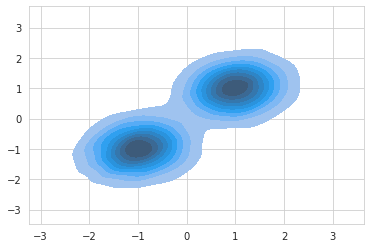

In [6]:
x1, x2 = true_mixture.rvs(size=10000).T
_ = sns.kdeplot(x=x1, y=x2, shade=True)

We use a standard multivariate normal for the noise, and again visualise the pdf and some samples:

In [7]:
noise = multivariate_normal([0,0], [[1, 0], [0, 1]])

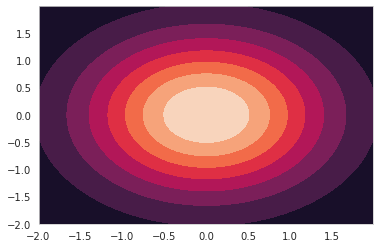

In [8]:
# Visualising the noise pdf
x1, x2 = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((x1, x2))
_ = plt.contourf(x1, x2, np.array([[noise.pdf(x) for x in p] for p in pos]))

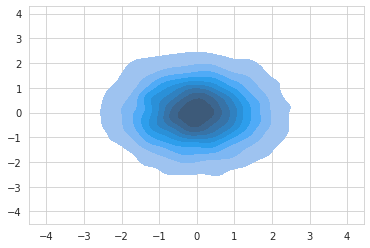

In [9]:
# Visualising our noise samples
x1, x2 = noise.rvs(size=10000).T
_ = sns.kdeplot(x=x1, y=x2, shade=True)

### Data - generation

In [10]:
N = 100000

In [11]:
X = np.concatenate([
    true_mixture.rvs(size=N),
    noise.rvs(size=N)
])
y = np.concatenate([
    np.ones(N),
    np.zeros(N)
])

In [12]:
# Use this if you don't care about having a train/test split - we'll use one for validation
# permutation = np.random.permutation(20000)
# X = X[permutation]
# y = y[permutation]
# y[:10]

In [13]:
, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
y_test

array([0., 1., 0., ..., 1., 0., 0.])

### Model - construction

In [15]:
from keras.models import Sequential
from keras.layers import Dense

In [16]:
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.predict(X_train[0:5])

array([[0.36330092],
       [0.49761403],
       [0.46138626],
       [0.35497582],
       [0.54805076]], dtype=float32)

In [19]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
2500/2500 [==============================] - 2s 853us/step - loss: 0.5612 - accuracy: 0.7225 - val_loss: 0.4994 - val_accuracy: 0.7776
Epoch 2/10
2500/2500 [==============================] - 2s 812us/step - loss: 0.4922 - accuracy: 0.7766 - val_loss: 0.4813 - val_accuracy: 0.7811
Epoch 3/10
2500/2500 [==============================] - 2s 786us/step - loss: 0.4828 - accuracy: 0.7790 - val_loss: 0.4763 - val_accuracy: 0.7822
Epoch 4/10
2500/2500 [==============================] - 2s 787us/step - loss: 0.4776 - accuracy: 0.7802 - val_loss: 0.4710 - val_accuracy: 0.7838
Epoch 5/10
2500/2500 [==============================] - 2s 786us/step - loss: 0.4721 - accuracy: 0.7817 - val_loss: 0.4669 - val_accuracy: 0.7853
Epoch 6/10
2500/2500 [==============================] - 2s 796us/step - loss: 0.4691 - accuracy: 0.7822 - val_loss: 0.4662 - val_accuracy: 0.7853
Epoch 7/10
2500/2500 [==============================] - 2s 784us/step - loss: 0.4677 - accuracy: 0.7830 - val_loss: 0.4645 -

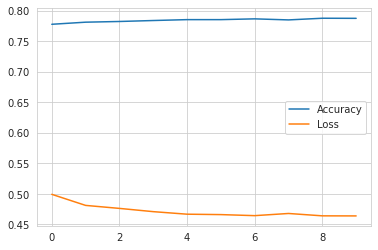

In [20]:
plt.plot(history.history['val_accuracy'], label='Accuracy')
plt.plot(history.history['val_loss'], label='Loss')
plt.legend()

### Results

Let's plot contour maps to check out the densities.

In [21]:
x1, x2 = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((x1, x2))

First let's recall our true pdf p:

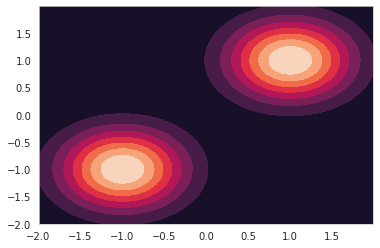

In [22]:
_ = plt.contourf(x1, x2, np.array([[true_mixture.pdf(x) for x in p] for p in pos]))

Now let's solve for our approximation to p:

$d = \frac{p}{p + q} \implies p = \frac{qd}{1 - d}$

In [23]:
d = model.predict(pos).reshape(400,400)
q = noise.pdf(pos)

In [24]:
p = q * d / (1 - d)

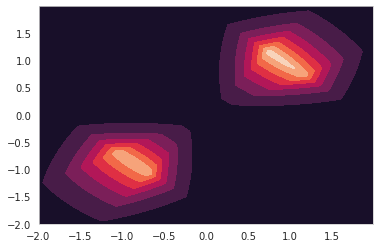

In [25]:
plt.contourf(x1, x2, p)

Not bad!